<a href="https://colab.research.google.com/github/debajyotidasgupta/BTP/blob/main/TF_Agents_Latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip3 install -U tf-agents[reverb] -q

     |████████████████████████████████| 1.3 MB 3.7 MB/s 
     |████████████████████████████████| 6.4 MB 20.1 MB/s 


In [3]:
from copy import deepcopy
from random import randint
import tensorflow as tf
import numpy as np
import reverb
import matplotlib.pyplot as plt

from tf_agents.eval import metric_utils
from tf_agents.utils import common
from tf_agents.specs import array_spec
from tf_agents.specs import tensor_spec
from tf_agents.drivers import py_driver
from tf_agents.metrics import tf_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.policies import policy_saver
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.networks import sequential
from tf_agents.agents.dqn import dqn_agent
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.environments import gym_wrapper
from tf_agents.trajectories import time_step as ts
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils

RuntimeError: ignored

In [77]:
import gym
from gym import spaces

class Job:
    def __init__(self, power, time, type_mc, name):
        '''
        Parameters
        ----------
        power: unit of power the process will consume,per unit time
        time : duration of the process (in minutes)
        '''
        self.id = randint(1, 10**5)
        self.name = name
        self.power = power
        self.type_mc = type_mc
        self.time = time

    def allocate(self, time, machine):
        '''
        Parameters
        ----------
        time: time to be allocated to the job
        machine: machine to be allocated to the job
        '''
        self.time = time
        self.machine = machine

class SmartApplEnv(gym.Env):
    def __init__(self, 
                 number_of_machines, # list of length same as number of different types of devices
                 number_of_jobs,     # list of length same as number of different types of devices
                 distinct_machines,
                 power_rate_chart, 
                 full_day, 
                 time_per_unit,
                 cycle_stat = None):
      
        self._state            = np.zeros((max(number_of_jobs), max(number_of_machines), distinct_machines))
        self.action_space      = spaces.Discrete(1+int(pow(2, max(number_of_machines))*pow(2, distinct_machines)))
        self.observation_space = spaces.Box(low=-1e20, high=1e20, shape=self._state.shape)
        
        self._episode_ended = False

        # Parameters related to different data statistics
        self.all_list         = [[] for _ in range(distinct_machines)]
        self.job_list         = [[] for _ in range(distinct_machines)]
        self.full_day         = full_day
        self.time_per_unit    = time_per_unit
        self.power_rate_chart = power_rate_chart

        self.max_jobs           = number_of_jobs
        self.max_machines       = number_of_machines
        self.distinct_machines  = distinct_machines
        self.number_of_jobs     = np.array(number_of_jobs    ).astype(np.int32)
        self.number_of_machines = np.array(number_of_machines).astype(np.int32)

        if cycle_stat != None:
            for m in range(distinct_machines):
                self.add_job(number_of_jobs[m], cycle_stat[m], m)
        _ = self.reset()

  
    def add_machine(self, machine):
      # correct this later
      machine_id = self.distinct_machines
      self.distinct_machines += 1
      return machine_id
    
    def add_job(self, num_jobs, cycle_stat, machine, set_val=False):
        # maxhine = 0 / 1 / 2 

        for _ in range(num_jobs):
            self.all_list[machine].append([])
            self.job_list[machine].append([])
            if set_val:
                self.number_of_jobs[machine] += 1
            
            for cycle in cycle_stat:
                self.all_list[machine][-1].append(
                    Job(cycle['power'],
                        (cycle['time'] + self.time_per_unit - 1) // self.time_per_unit,
                        machine,
                        cycle['cycle']))
                
                self.job_list[machine][-1].append(
                    Job(cycle['power'],
                        (cycle['time'] + self.time_per_unit - 1) // self.time_per_unit,
                        machine,
                        cycle['cycle']))


    def amount_for_bill(self, power):
        amount = 0
        pos = -1
        # Get the time of the day when the scheduling is currently being done in the power stat chart
        for time_limit in sorted(self.power_rate_chart, reverse=True):
            if time_limit < self.time:
                break
            pos = time_limit

        # Get the power rate for the current time
        amount = self.power_rate_chart[pos]['cost'] * \
            power * self.time_per_unit

        # If the power consumption crosses the threshold, then the penalization is applied
        if power > self.power_rate_chart[pos]['limit']:
            amount += (power - self.power_rate_chart[pos]['limit']) * \
                self.power_rate_chart[pos]['penalty'] * self.time_per_unit
        return amount

    def generate_state_encoding(self):
        MN, MX = -300, 0
        image = np.zeros(self._state.shape, dtype=np.float32)

        pos = -1
        # Get the time of the day when the scheduling is currently being done in the power stat chart
        for time_limit in sorted(self.power_rate_chart, reverse=True):
            if time_limit < self.time:
                break
            pos = time_limit

        for m in range(self.distinct_machines):
            for i in range(self.number_of_jobs[m]):
                for j in range(self.number_of_machines[m]):
                    if self.machine_free_time[m, j] <= self.time\
                            and self.job_free_time[m, i] <= self.time\
                            and (self.job_allocation_list[m, i] == -1 or
                                self.job_allocation_list[m, i] == j)\
                            and (self.machine_allocation_list[m, j] == -1 or
                                self.machine_allocation_list[m, j] == i)\
                            and len(self.job_list[m][i]) > 0:

                        image[i, j, m] = self.job_list[m][i][0].power -\
                            self.power_rate_chart[pos]['limit']
                        #another idea can be to use the get_cost  method

                        MX = max(MX, image[i, j, m])
                    else:
                        image[i, j, m] = MN
        # plt.imshow(image, cmap="hot")
        return image / max(1, MX)  # changed this line

    def reset(self):
        # Make the job list from the data of the cycles on machines
        self.job_list = deepcopy(self.all_list)

        # parameters describing the state of the environment
        self.time = 0
        self.machine_free_time       = np.zeros((self.distinct_machines, np.max(self.number_of_machines)), dtype=np.int32)
        self.job_free_time           = np.zeros((self.distinct_machines, np.max(self.number_of_jobs)),     dtype=np.int32)
        self.machine_allocation_list = np.zeros((self.distinct_machines, np.max(self.number_of_machines)), dtype=np.int32) - 1
        self.job_allocation_list     = np.zeros((self.distinct_machines, np.max(self.number_of_jobs)),     dtype=np.int32) - 1

        self.bill = 0
        self._state = self.generate_state_encoding()
        self._episode_ended = False
        # print(self._state.shape)
        return self._state

    def schedule(self, machine, action):
        power, reward = 0, 0

        for m in range(self.distinct_machines):
            for i in range(self.number_of_machines[m]):
                if action & (1 << i):
                    if self.machine_free_time[m, i] <= self.time:
                        if self.machine_allocation_list[m, i] == -1:
                            for j in range(self.number_of_jobs[m]):
                                if self.job_free_time[m, j] == 0:
                                    self.machine_allocation_list[m, i] = j
                                    self.job_allocation_list[m, j] = i

                                    reward += 20000.
                                    break

                        job = self.machine_allocation_list[m, i]
                        if job == -1:
                            continue

                        self.job_free_time[m, job] += self.job_list[m][job][0].time
                        self.machine_free_time[m, i] += self.job_list[m][job][0].time
                        power += self.job_list[m][job][0].power

                        reward += 10000. * self.job_list[m][job][0].time
                        self.job_list[m][job].pop(0)

                        if len(self.job_list[m][job]) == 0:
                            reward += 500000.
                            self.machine_allocation_list[m, i] = -1
                            self.job_allocation_list[m, job] = -1
                    else:
                        reward -= 1500.
        return power, reward


    def step(self, action):
        if self._episode_ended:
            return self.reset()

        # actions += 1
        reward, done, info = -100., False, {} # make 10. -> 100.
        power = 0


        for machine in range(self.distinct_machines):
            if action < self.action_space.n - 1:
                mask   = action % int(pow(2, self.number_of_machines[machine]))
                action = action // int(pow(2, self.number_of_machines[machine]))
                cur_pow, cur_rew = self.schedule(machine, mask)
                power  += cur_pow
                reward += cur_rew
            
            for i in self.job_list[machine]:
                reward -= len(i) * 100.  # make this 1000.

        reward -= self.amount_for_bill(power) * 100
        self.bill += self.amount_for_bill(power)

        self.time += 1
        if self.time == self.full_day:
            done = True
        
        self._state = self.generate_state_encoding()
        self._episode_ended = done
        info = {}

        return self._state, reward, self._episode_ended, info
    
    def render(self, args):
        fig, ax = plt.subplots(1, 3, figsize=(5, 5))
        for i in range(self._state.shape[2]):
            ax[i].imshow(self._state[:,:,i])
            ax[i].grid(False)

In [78]:
power = {
    240:  {"cost": 10,"limit": 110,"penalty": 450},
    480:  {"cost": 30,"limit": 110,"penalty": 290},
    720:  {"cost": 80,"limit": 200,"penalty": 50},
    960:  {"cost": 45,"limit": 170,"penalty": 180},
    1200: {"cost": 20,"limit": 140,"penalty": 380},
    1440: {"cost": 5,"limit": 230,"penalty": 550}
}


machine1 = [
    {"cycle": "Water Fill", "power": 0,      "time": 10},
    {"cycle": "Agitation",  "power": 3.97,   "time": 10},
    {"cycle": "Wash",       "power": 70.05,  "time": 15},
    {"cycle": "Drain",      "power": 0,      "time": 5},
    {"cycle": "Spin",       "power": 11.53,  "time": 5},
    {"cycle": "Water Fill", "power": 0,      "time": 10},
    {"cycle": "Rinse",      "power": 21.14,  "time": 5},
    {"cycle": "Drain",      "power": 0,      "time": 5},
    {"cycle": "Spin",       "power": 28.09,  "time": 10}
]
machine2 = [{"cycle": "microwave","power": 50,"time" : 10,}]
machine3 = [{"cycle": "AC","power": 100,"time" : 25,}]

#Hyperparameters

In [79]:
N_MACHINES = [7,7,7]
N_JOBS = [40,40,40]
UNIT = 5
TIME = 2000
VISUALIZE = False

num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

#Environment

In [80]:
gym_env = SmartApplEnv(number_of_machines=N_MACHINES,
                   number_of_jobs=N_JOBS,
                   distinct_machines=3,
                   power_rate_chart=power,
                   full_day= TIME // UNIT,
                   time_per_unit=UNIT,
                   cycle_stat = [machine1, machine2, machine3]
                  )

In [81]:
py_env = gym_wrapper.GymWrapper(gym_env)
tf_env = tf_py_environment.TFPyEnvironment(py_env)

#Agent

In [82]:
action_tensor_spec = tensor_spec.from_spec(py_env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

layers = [
    tf.keras.layers.Conv2D(128,  (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (1, 1), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,  (3, 3), padding='same', activation='relu'),
    tf.keras.layers.AvgPool2D(padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32,  (3, 3), padding='same', activation='relu'),
    tf.keras.layers.AvgPool2D(padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='truncated_normal')),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='truncated_normal')),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(8,  activation='relu', kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='truncated_normal')),
    tf.keras.layers.Dropout(0.2)
]

q_values_layer = tf.keras.layers.Dense(num_actions, activation=None, kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.03, maxval=0.03), bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(layers + [q_values_layer])

In [83]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

update_period = 4 # train the model every 4 steps
optimizer = tf.keras.optimizers.RMSprop(learning_rate=2.5e-4, rho=0.95, momentum=0.0, epsilon=0.00001, centered=True)
train_step_counter = tf.Variable(0)

# epsilon_fn = tf.keras.optimizers.schedules.PolynomialDecay(
#     initial_learning_rate=1.0, # initial ε
#     decay_steps=num_iterations // update_period, # <=> 1,000,000 ALE frames
#     end_learning_rate=0.01) # final ε

agent = dqn_agent.DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    debug_summaries = True,
    summarize_grads_and_vars = True,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter,
    # epsilon_greedy=lambda: epsilon_fn(train_step_counter),
)

agent.initialize()

In [84]:
q_net.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           multiple                  3584      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 multiple                  0         
_________________________________________________________________
batch_normalization_14 (Batc multiple                  512       
_________________________________________________________________
conv2d_15 (Conv2D)           multiple                  16512     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 multiple                  0         
_________________________________________________________________
batch_normalization_15 (Batc multiple                  512       
_________________________________________________________________
conv2d_16 (Conv2D)           multiple                 

#Policies

In [85]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [86]:
random_policy = random_tf_policy.RandomTFPolicy(tf_env.time_step_spec(),
                                                tf_env.action_spec())
time_step = tf_env.reset()
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([246])>, state=(), info=())

#Metrics and Evaluation

In [87]:
def compute_min_avg_return(environment, python_env, policy, num_episodes=10):
  total_return = 0.0
  min_bill = float('inf')

  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return
    min_bill = min(min_bill, python_env.bill)

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0], min_bill

In [114]:
compute_min_avg_return(tf_env, py_env, random_policy, num_eval_episodes)
# print('\n',py_env.bill)
# print([len(i) for i in py_env.job_list[0]])
# print([len(i) for i in py_env.job_list[1]])
# print([len(i) for i in py_env.job_list[2]])

(-1218078600.0, 12157307.5)

#Replay Buffer

In [89]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

#Data Collection



In [90]:
py_driver.PyDriver(
    py_env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(py_env.reset())

(TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([[[-300.  , -300.  , -300.  ],
        [-300.  , -300.  , -300.  ],
        [-300.  , -300.  , -300.  ],
        [-300.  , -300.  , -300.  ],
        [-300.  , -300.  , -300.  ],
        [-300.  , -300.  , -300.  ],
        [-300.  , -300.  , -300.  ]],

       [[-300.  , -300.  , -300.  ],
        [-300.  , -300.  , -300.  ],
        [-300.  , -300.  , -300.  ],
        [-300.  , -300.  , -300.  ],
        [-300.  , -300.  , -300.  ],
        [-300.  , -300.  , -300.  ],
        [-300.  , -300.  , -300.  ]],

       [[-300.  , -300.  , -300.  ],
        [-300.  , -300.  , -300.  ],
        [-300.  , -300.  , -300.  ],
        [-300.  , -300.  , -300.  ],
        [-300.  , -300.  , -300.  ],
        [-300.  , -300.  , -300.  ],
        [-300.  , -300.  , -300.  ]],

       [[-300.  , -300.  , -300.  ],
        [-300.  , -300.  , -300.  ],
        [-300.  , -300.  , -300.  ],
        [-300.  , -300.  , -300.  ],
   

In [91]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

<PrefetchDataset shapes: (Trajectory(
{action: (64, 2),
 discount: (64, 2),
 next_step_type: (64, 2),
 observation: (64, 2, 40, 7, 3),
 policy_info: (),
 reward: (64, 2),
 step_type: (64, 2)}), SampleInfo(key=(64, 2), probability=(64, 2), table_size=(64, 2), priority=(64, 2))), types: (Trajectory(
{action: tf.int64,
 discount: tf.float32,
 next_step_type: tf.int32,
 observation: tf.float32,
 policy_info: (),
 reward: tf.float32,
 step_type: tf.int32}), SampleInfo(key=tf.uint64, probability=tf.float64, table_size=tf.int64, priority=tf.float64))>

In [92]:
iterator = iter(dataset)
print(iterator)

In [93]:
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return, min_bill = compute_min_avg_return(tf_env, py_env, agent.policy, num_eval_episodes)
returns = [(avg_return, min_bill)]

# Reset the environment.
time_step = py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    py_env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

max_reward = float('-inf')
tf_policy_saver = policy_saver.PolicySaver(agent.policy, batch_size=None)

for it in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return, min_bill = compute_min_avg_return(tf_env, py_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}, Minimum Bill = {2}\n'.format(step, avg_return, min_bill))
    returns.append((avg_return, min_bill))

    if avg_return > max_reward:
      max_reward = avg_return
      policy = agent.collect_policy
      tf_policy_saver.save(f'policy_{it+1}')
      print(f"Saved Model at [policy_{it+1}]\n")

CPU times: user 0 ns, sys: 13 µs, total: 13 µs
Wall time: 25.5 µs
step = 200: loss = 203645421355008.0
step = 400: loss = 697282169143296.0
step = 600: loss = 75752150138880.0
step = 800: loss = 14799461154816.0
step = 1000: loss = 336446934220800.0


step = 1000: Average Return = -1304895488.0, Minimum Bill = 13714498.5



INFO:tensorflow:Assets written to: policy_999/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:561: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)
INFO:tensorflow:Assets written to: policy_999/assets


Saved Model at [policy_999]

step = 1200: loss = 136514746974208.0
step = 1400: loss = 154887744651264.0
step = 1600: loss = 229225407709184.0
step = 1800: loss = 489555304120320.0
step = 2000: loss = 175451930624000.0
step = 2000: Average Return = -1471595648.0, Minimum Bill = 15381241.5

step = 2200: loss = 196406102982656.0
step = 2400: loss = 59328513966080.0
step = 2600: loss = 185508344889344.0
step = 2800: loss = 348577666695168.0
step = 3000: loss = 260550265143296.0


step = 3000: Average Return = -1084391808.0, Minimum Bill = 11487482.0



INFO:tensorflow:Assets written to: policy_2999/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:561: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)
INFO:tensorflow:Assets written to: policy_2999/assets


Saved Model at [policy_2999]

step = 3200: loss = 591626577641472.0
step = 3400: loss = 35331302752256.0
step = 3600: loss = 125163358126080.0
step = 3800: loss = 160120541544448.0
step = 4000: loss = 669541109596160.0
step = 4000: Average Return = -1521934592.0, Minimum Bill = 15899035.0

step = 4200: loss = 297547415420928.0
step = 4400: loss = 686466434859008.0
step = 4600: loss = 487155960905728.0
step = 4800: loss = 185847143989248.0
step = 5000: loss = 344327528120320.0
step = 5000: Average Return = -1521934592.0, Minimum Bill = 15899035.0

step = 5200: loss = 270489289228288.0
step = 5400: loss = 572623629058048.0
step = 5600: loss = 307129755893760.0
step = 5800: loss = 844340372963328.0
step = 6000: loss = 789353987047424.0
step = 6000: Average Return = -1522173568.0, Minimum Bill = 15899035.0

step = 6200: loss = 218859286036480.0
step = 6400: loss = 119605343289344.0
step = 6600: loss = 483029000650752.0
step = 6800: loss = 188659156385792.0
step = 7000: loss = 4663188935147

step = 8000: Average Return = -1061035648.0, Minimum Bill = 11262482.0



INFO:tensorflow:Assets written to: policy_7999/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:561: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)
INFO:tensorflow:Assets written to: policy_7999/assets


Saved Model at [policy_7999]

step = 8200: loss = 233508463181824.0
step = 8400: loss = 113016595021824.0
step = 8600: loss = 117058092138496.0
step = 8800: loss = 155510145810432.0
step = 9000: loss = 297424673308672.0
step = 9000: Average Return = -1646751872.0, Minimum Bill = 17151250.0

step = 9200: loss = 28767374278656.0
step = 9400: loss = 170232891047936.0
step = 9600: loss = 305712953556992.0
step = 9800: loss = 111621552734208.0
step = 10000: loss = 25349607915520.0
step = 10000: Average Return = -1521677440.0, Minimum Bill = 15899035.0

step = 10200: loss = 51341435076608.0
step = 10400: loss = 477583082782720.0
step = 10600: loss = 47425653833728.0
step = 10800: loss = 96919024041984.0
step = 11000: loss = 449630194106368.0
step = 11000: Average Return = -1305472000.0, Minimum Bill = 13718199.5

step = 11200: loss = 285123215884288.0
step = 11400: loss = 931893348401152.0
step = 11600: loss = 86521512198144.0
step = 11800: loss = 909550458765312.0
step = 12000: loss = 26857

step = 13000: Average Return = -997918336.0, Minimum Bill = 10640616.0



INFO:tensorflow:Assets written to: policy_12999/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:561: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)
INFO:tensorflow:Assets written to: policy_12999/assets


Saved Model at [policy_12999]

step = 13200: loss = 619982421491712.0
step = 13400: loss = 28526010957824.0
step = 13600: loss = 774552724439040.0
step = 13800: loss = 71733872689152.0
step = 14000: loss = 291968856883200.0
step = 14000: Average Return = -1463707776.0, Minimum Bill = 15308409.5

step = 14200: loss = 156760736268288.0
step = 14400: loss = 60864661028864.0
step = 14600: loss = 119684280090624.0
step = 14800: loss = 64685361594368.0
step = 15000: loss = 165475963109376.0
step = 15000: Average Return = -1034460032.0, Minimum Bill = 11001736.5

step = 15200: loss = 585265865293824.0
step = 15400: loss = 186269443293184.0
step = 15600: loss = 317087201361920.0
step = 15800: loss = 60608590381056.0
step = 16000: loss = 186231258349568.0
step = 16000: Average Return = -1069130880.0, Minimum Bill = 11349568.5

step = 16200: loss = 63479918624768.0
step = 16400: loss = 218841418301440.0
step = 16600: loss = 251869632921600.0
step = 16800: loss = 626067853279232.0
step = 17000: l

step = 19000: Average Return = -955398528.0, Minimum Bill = 10206811.5



INFO:tensorflow:Assets written to: policy_18999/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:561: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)
INFO:tensorflow:Assets written to: policy_18999/assets


Saved Model at [policy_18999]

step = 19200: loss = 126013870702592.0
step = 19400: loss = 37104239247360.0
step = 19600: loss = 411200638681088.0
step = 19800: loss = 7801705550839808.0
step = 20000: loss = 53423655354368.0


step = 20000: Average Return = -918684032.0, Minimum Bill = 9848829.0



INFO:tensorflow:Assets written to: policy_19999/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:561: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)
INFO:tensorflow:Assets written to: policy_19999/assets


Saved Model at [policy_19999]



Text(0.5, 0, 'Iterations')

<Figure size 432x288 with 0 Axes>

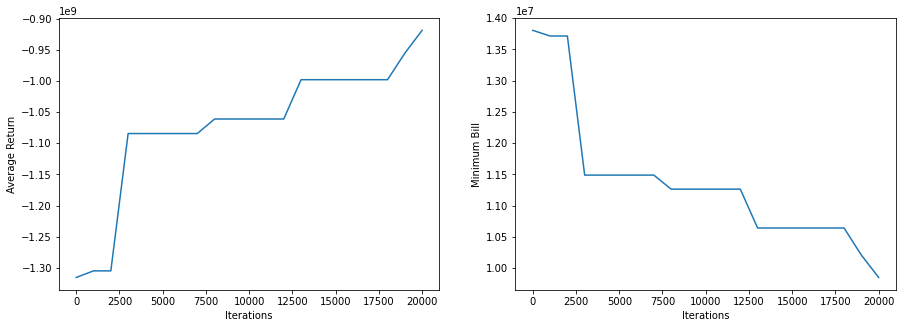

In [113]:
iterations = range(0, num_iterations + 1, eval_interval)

plt.subplots_adjust(wspace = 1.7)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

avg = [i[0] for i in returns]
mnm = [i[1] for i in returns]  

for i in range(1, len(avg)): avg[i] = max(avg[i-1], avg[i])
for i in range(1, len(mnm)): mnm[i] = min(mnm[i-1], mnm[i])

ax[0].plot(iterations, avg)
ax[1].plot(iterations, mnm)

ax[0].set_ylabel('Average Return')
ax[1].set_ylabel('Minimum Bill')

ax[0].set_xlabel('Iterations')
ax[1].set_xlabel('Iterations')

# ax[0].set_ylim(top=250)
# ax[0].set_ylim(top=250)

In [106]:
saved_policy = tf.saved_model.load('policy_19999')

time_step = tf_env.reset()
while not time_step.is_last():
  action_step = saved_policy.action(time_step)
  time_step = tf_env.step(action_step.action)

print(py_env.bill)
print([len(i) for i in py_env.job_list[0]])
print([len(i) for i in py_env.job_list[1]])
print([len(i) for i in py_env.job_list[2]])

9848829.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 6, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [115]:
!zip -r policy_19999.zip policy_19999/

  adding: policy_19999/ (stored 0%)
  adding: policy_19999/saved_model.pb (deflated 90%)
  adding: policy_19999/policy_specs.pbtxt (deflated 86%)
  adding: policy_19999/assets/ (stored 0%)
  adding: policy_19999/variables/ (stored 0%)
  adding: policy_19999/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: policy_19999/variables/variables.index (deflated 63%)
